# Simulated Annealing Demo

Skrypt przedstawia przykładową implementację algorytmu symulowanego wyżarzania (ang. Simulated Annealing, SA) i jego zastosowanie do rozwiązywania problemu Quadratic Assignment Problem (QAP). Problem jest dokładnie opisany m.in. w pracy Burkarda i innych [1]. Popularne instancje problemu QAP można znaleźć w bibliotece QAPLib [2]. Skrypt skupia się na rozwiązywaniu instancji NUG12 [3], w celu rozwiązywania innych instancji może okazać się konieczna zmiana ustawień parametrów algorytmu.

Literatura:

[1]  Burkard, R., Cela, E., Pardalos, P., Pitsoulis, L., "The Quadratic Assignment Problem", http://citeseerx.ist.psu.edu/viewdoc/summary?doi=10.1.1.217.1914

[2] QAPLIB, http://anjos.mgi.polymtl.ca/qaplib/

[3] NUG12, http://anjos.mgi.polymtl.ca/qaplib/data.d/nug12.dat

In [1]:
def log_progress(sequence, every=None, size=None, name='Items'):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = int(size / 200)     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{name}: {index} / ?'.format(
                        name=name,
                        index=index
                    )
                else:
                    progress.value = index
                    label.value = u'{name}: {index} / {size}'.format(
                        name=name,
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = "{name}: {index}".format(
            name=name,
            index=str(index or '?')
        )

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import time
import urllib
from IPython.lib import backgroundjobs as bg

%matplotlib inline

In [5]:
QAP_INSTANCE_URL = 'http://anjos.mgi.polymtl.ca/qaplib/data.d/nug12.dat'

## Reading input data

In [6]:
qap_instance_file = urllib.urlopen(QAP_INSTANCE_URL)

line = qap_instance_file.readline()
n = int(line.decode()[:-1].split()[0])
print('Problem size: %d' % n)
print(line.decode())

A = np.empty((n, n))
qap_instance_file.readline()
for i in range(n):
    line = qap_instance_file.readline()
    A[i, :] = list(map(int, line.decode()[:-1].split()))
print('Flow matrix:\n', A)

B = np.empty((n, n))
qap_instance_file.readline()
for i in range(n):
    line = qap_instance_file.readline()
    B[i, :] = list(map(int, line.decode()[:-1].split()))
print('Distance matrix:\n', B)

Problem size: 12
12

('Flow matrix:\n', array([[ 0.,  1.,  2.,  3.,  1.,  2.,  3.,  4.,  2.,  3.,  4.,  5.],
       [ 1.,  0.,  1.,  2.,  2.,  1.,  2.,  3.,  3.,  2.,  3.,  4.],
       [ 2.,  1.,  0.,  1.,  3.,  2.,  1.,  2.,  4.,  3.,  2.,  3.],
       [ 3.,  2.,  1.,  0.,  4.,  3.,  2.,  1.,  5.,  4.,  3.,  2.],
       [ 1.,  2.,  3.,  4.,  0.,  1.,  2.,  3.,  1.,  2.,  3.,  4.],
       [ 2.,  1.,  2.,  3.,  1.,  0.,  1.,  2.,  2.,  1.,  2.,  3.],
       [ 3.,  2.,  1.,  2.,  2.,  1.,  0.,  1.,  3.,  2.,  1.,  2.],
       [ 4.,  3.,  2.,  1.,  3.,  2.,  1.,  0.,  4.,  3.,  2.,  1.],
       [ 2.,  3.,  4.,  5.,  1.,  2.,  3.,  4.,  0.,  1.,  2.,  3.],
       [ 3.,  2.,  3.,  4.,  2.,  1.,  2.,  3.,  1.,  0.,  1.,  2.],
       [ 4.,  3.,  2.,  3.,  3.,  2.,  1.,  2.,  2.,  1.,  0.,  1.],
       [ 5.,  4.,  3.,  2.,  4.,  3.,  2.,  1.,  3.,  2.,  1.,  0.]]))
('Distance matrix:\n', array([[  0.,   5.,   2.,   4.,   1.,   0.,   0.,   6.,   2.,   1.,   1.,
          1.],
       [  5.,   0.

## Objective function

In [7]:
def qap_objective_function(p):
    s = 0.0
    for i in range(n):
        s += (A[i, :] * B[p[i], p]).sum()
    return s

In [13]:
p = np.array([11, 6, 8, 2, 3, 7, 10, 0, 4, 5, 9, 1])
print(qap_objective_function(p), p)

(578.0, array([11,  6,  8,  2,  3,  7, 10,  0,  4,  5,  9,  1]))


## Simulated Annealing

In [8]:
def random_neighbor(p, radius):
    q = p.copy()
    for r in range(radius):
        i, j = np.random.choice(n, 2, replace=False)
        q[i], q[j] = q[j], q[i]
    return q

In [2]:
T = 200000
I = 2000
DIVS = 8
II = I // DIVS

radius = 6
alpha = 2.00

In [12]:
def sim_ann(ident):
    t0 = time.time()
    costs_in_iterations = np.zeros(II)
    for i in range(II):
        p = np.random.permutation(n)
        p_cost = qap_objective_function(p)
        costs = np.zeros(T)
        for t in range(T):
            q = random_neighbor(p, radius)
            q_cost = qap_objective_function(q)
            if(q_cost < p_cost):
                p, p_cost = q, q_cost
            elif(np.random.rand() < np.exp(- alpha * (q_cost - p_cost) * t/T)):
                p, p_cost = q, q_cost
            costs[t] = p_cost
        costs_in_iterations[i] = costs.min()
    np.savetxt("computation_" + str(ident), costs_in_iterations)
    print ("Process " + str(ident) + " finished", time.time() - t0)
    return costs_in_iterations

In [ ]:
import concurrent.futures as cf
outs = []

with cf.ProcessPoolExecutor() as executor:
    for i in range(DIVS):
        outs.append(executor.submit(sim_ann, i))


In [5]:
outs = []
for i in range(DIVS):
    outs.append(np.loadtxt("computation_" + str(i)))

In [ ]:
np.savetxt("ASS_LONG_COMPUTATIONS.txt", costs)

In [12]:
stacked = np.hstack(outs)
print stacked
print len(stacked)

[ 600.  586.  586. ...,  590.  594.  598.]
2000


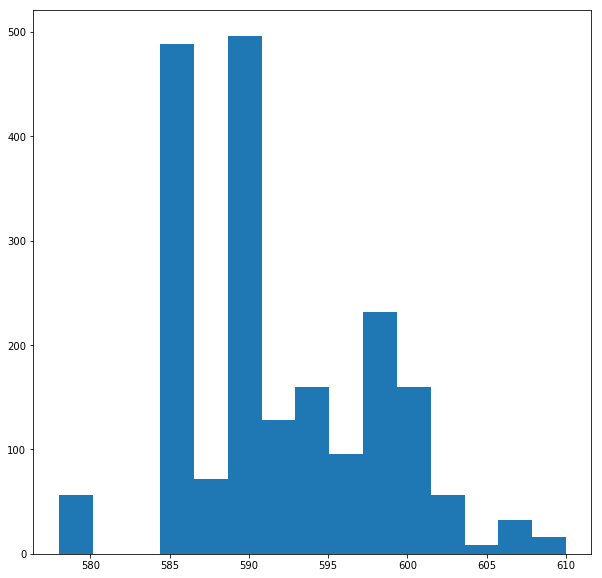

In [14]:
plt.figure(figsize=(10,10))
plt.hist(stacked, bins=15)
plt.show()

In [9]:
def distance(p1, p2):
    return np.sum(np.less.outer(p1, p1) & np.transpose(np.less.outer(p2,p2)))

In [10]:
def sim_ann():
    p = np.random.permutation(n)
    p_cost = qap_objective_function(p)
    costs = np.zeros(T)
    acc = np.zeros(T)
    succ = np.zeros(T)
    dists = np.zeros(T)
    subs = np.zeros(T)
    a = 0
    s = 0
    for t in log_progress(range(T)):
        q = random_neighbor(p, radius)
        q_cost = qap_objective_function(q)
        dists[t] = distance(p,q)
        subs[t] = p_cost - q_cost
        if(q_cost < p_cost):
            s += 1
            p, p_cost = q, q_cost
        elif(np.random.rand() < np.exp(- alpha * (q_cost - p_cost) * t/T)):
            a += 1
            p, p_cost = q, q_cost
        costs[t] = p_cost
        acc[t] = a
        succ[t] = s
    return costs, acc, succ, dists, subs

In [11]:
T = 1000000
radius = 4
alpha = 1

cost, acc, succ, dists, subs = sim_ann()

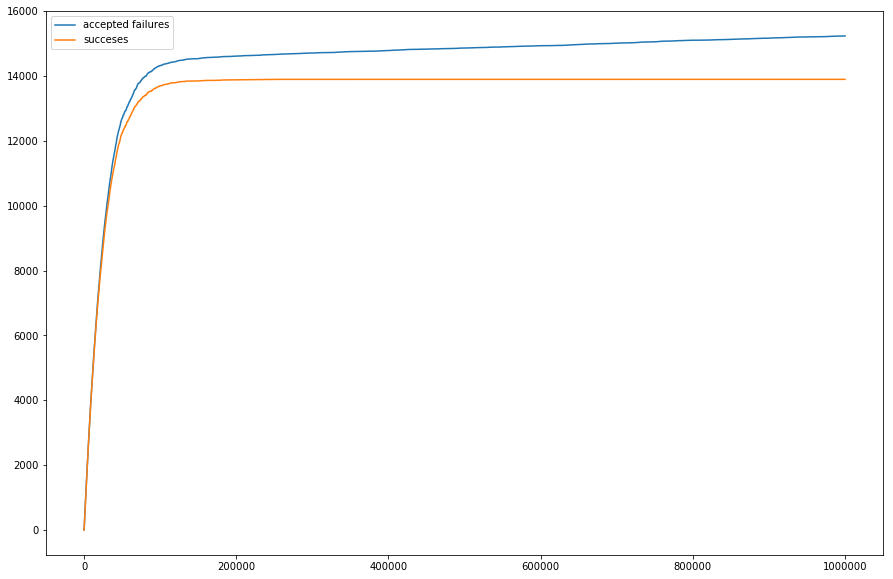

In [12]:
plt.figure(figsize=(15,10))
plt.plot(acc, label='accepted failures')
plt.plot(succ, label='succeses')
plt.legend()
plt.show()

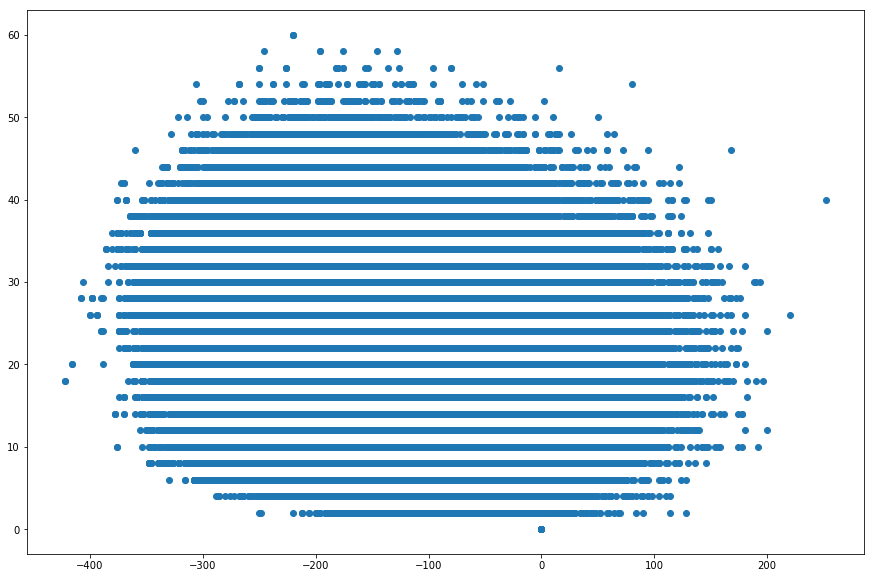

In [15]:
plt.figure(figsize=(15,10))
plt.scatter(subs, dists)
plt.show()

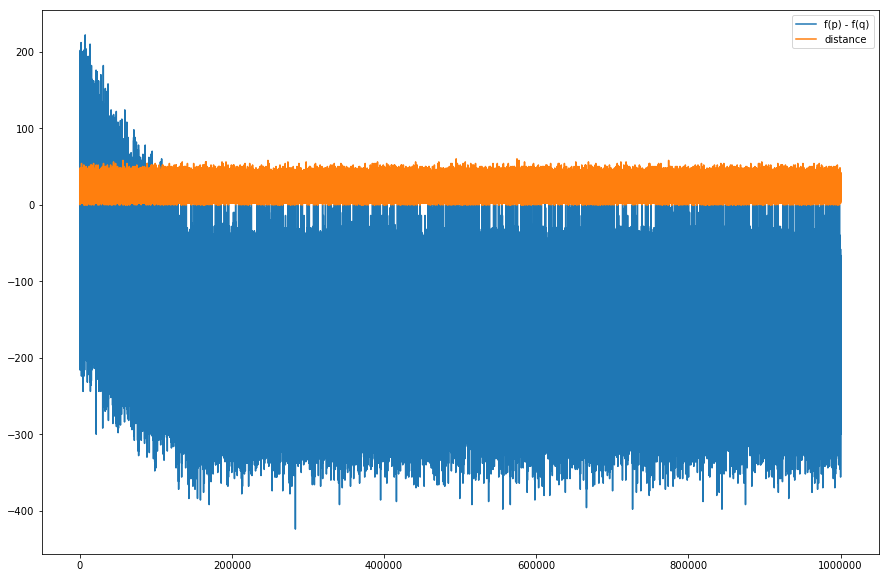

In [54]:
plt.figure(figsize=(15,10))
plt.plot(subs, label='f(p) - f(q)')
plt.plot(dists, label='distance')
plt.legend()
plt.show()

In [55]:
cost.min()

578.0